Scipy example
===

Here we will perform a variation of the fit example using Scipy.

In [1]:
# This code example below was generated by Claude-3.5.
import numpy as np

def generate_random_data(pdf, x_range, num_samples=1000, num_bins=1000):
    """
    Generate random data using an arbitrary positive definite function as PDF.
    
    Parameters:
    pdf (callable): The probability density function
    x_range (tuple): The range of x values (min_x, max_x)
    num_samples (int): Number of samples to generate
    num_bins (int): Number of bins for discretization
    
    Returns:
    numpy.ndarray: Array of generated random data
    """
    
    min_x, max_x = x_range
    x = np.linspace(min_x, max_x, num_bins)
    y = pdf(x)
    
    # Ensure the function is non-negative
    if np.any(y < 0):
        raise ValueError("The input function must be non-negative in the given range")
    
    # Normalize the function to make it a valid PDF
    y_normalized = y / np.trapz(y, x)
    
    # Find the maximum value of the normalized PDF
    y_max = np.max(y_normalized)
    
    # Generate random samples using rejection sampling
    samples = []
    while len(samples) < num_samples:
        x_proposed = np.random.uniform(min_x, max_x)
        y_proposed = np.random.uniform(0, y_max)
        
        if y_proposed < pdf(x_proposed) / np.trapz(y, x): # notice how the AI includes this inefficiency
            samples.append(x_proposed)                    # can you speed this code up in the 2nd cell below?
    
    return np.array(samples)

In [5]:
# a function with three parameters
def sample_pdf(x, p0=0.5, p1=2, p2=25, p3=.1, norm=1.0):
        return norm*(p0 * np.exp(-(x - p1)**2 / 0.5) + x*x/p2 + p3)

In [3]:
%%timeit
data = generate_random_data(sample_pdf, (-5, 5), num_samples=10000)
# comment out this cell to go faster 

187 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


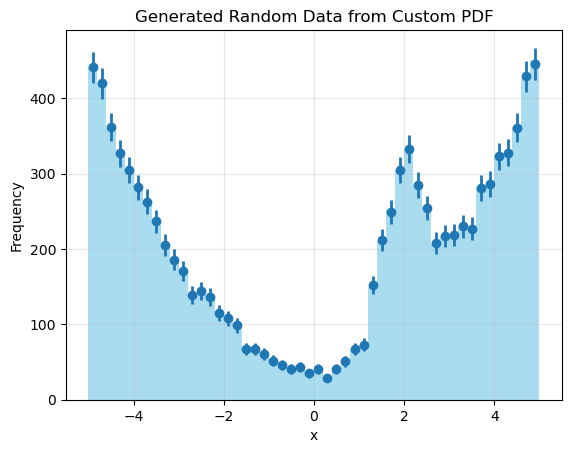

In [6]:
# back to the main project
import matplotlib.pyplot as plt

xrange=(-5,5)
nbins=50
data = generate_random_data(sample_pdf, xrange, num_samples=10000)
y,bins=np.histogram(data, bins=nbins, range=xrange)
yerr=np.sqrt(y)
x=(bins[:-1]+bins[1:])/2

plt.hist(data, bins=nbins, density=False, alpha=0.7, color='skyblue')

plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Generated Random Data from Custom PDF')
plt.errorbar(x, y, yerr, fmt='o', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

Perform a fit using [scipy.optimize.curvefit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
---

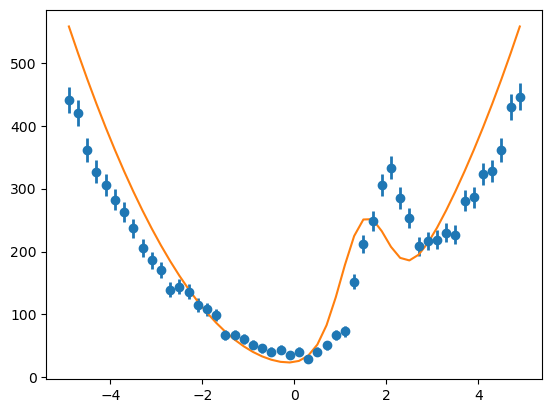

In [15]:
# fit the function sample_pdf to the data (x, y, yerr)
# first we need to 'guess' at initial parameters 
# (pretending here that we don't already know them)
params=[.4,1.5,20,0.05,y.max()]
ytmp = sample_pdf(x,*params)
plt.errorbar(x, y, yerr, fmt='o', linewidth=2)
plt.plot(x,ytmp)

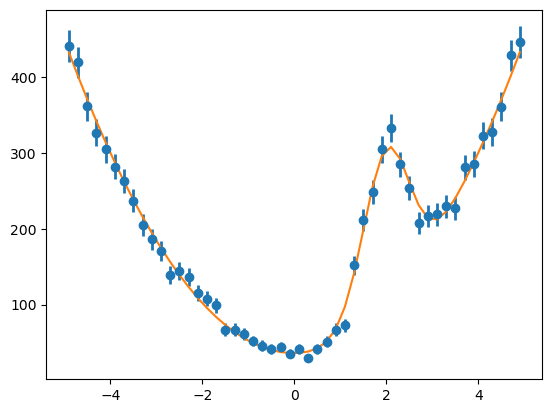

In [26]:
# that wasn't too bad for a 'guess'
# let's try fitting
from scipy.optimize import curve_fit
popt,pcov = curve_fit(sample_pdf, x, y, p0=params, sigma=yerr, absolute_sigma=True)
# the return values are the optimized parameters and the covariance matrix

# now let's see how the fit looks
plt.errorbar(x, y, yerr, fmt='o', linewidth=2)
ytmp = sample_pdf(x,*popt)
plt.plot(x,ytmp)
from scipy.stats import chisquare
print chi^2=(f_obs, f_exp=None, ddof=0, axis=0)

In [27]:
# extract the parabolic errors from the covariance function
perr = [] 
for i in range(len(popt)):
    try:
        perr.append(np.sqrt(pcov[i][i]))
    except:
        perr.append( 0.00 )
print(popt)
print(perr) 

[5.82125206e-01 1.99290942e+00 2.11741203e+01 1.02450006e-01
 3.50290461e+02]
[657811.5020742866, 0.021324659242029777, 23927120.587870944, 115770.26978764652, 395834247.05501384]


Wow, those errors look crazy!  I'm not sure what to tell you, except that I recommend using a package like [ROOT](https://root.cern.ch/), [lmfit](https://lmfit.github.io/lmfit-py/), or [iminuit](https://scikit-hep.org/iminuit/) instead!  The model above may have parameter correlations that are too strong for the scipy minimzer to do a proper error estimation.  

In [33]:
# want the chi^2?  you need to do it on your own
chi2=np.square((y-ytmp)/yerr).sum()
import scipy.stats as stats
ndof=len(x)-len(popt)
p_value = 1 - stats.chi2.cdf(chi2, ndof)
print(f"chi2 = {chi2:0.2f} p-value = {p_value:0.2g}")

chi2 = 37.50 p-value = 0.78


For you to try
===
The file datadist.root you will find a histogram representing data from an unknown distribution.

* Develop your own fitting function/model and see how well you can fit this distribution. 
* You may need to try a variety of functions.
* Include a plot of your best fit at the bottom of this notebook.
* Include your p-value for the best fit and describe how you settled on this fit versus others.
* Show your best fit parameters and their errors
* Plot the fit residuals, eg for each bin plot (fit-data)/data_uncertianty.  For a good fit the points should randomy fluctuate around 0 (eg no large, contiguous regions above or below 0)
* Plot the pull distribution (for a good fit this should be consisten with a normal distribution w/ $\mu=0,\sigma=1$

For this notebook it is assumed that you'll woth with scipy.optimize.curve_fit.  Below, we'll first conver the ROOT instogram into numpy arrays.

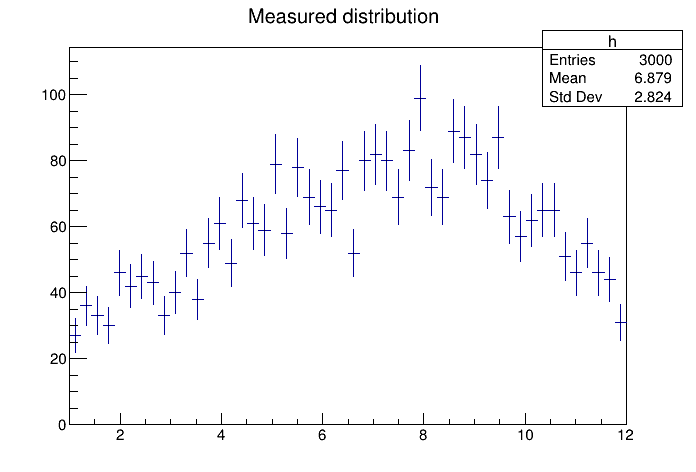

In [78]:
tf=r.TFile("datadist.root")
hist=tf.Get("h")
tc=r.TCanvas()
hist.Draw()
tc.Draw()

In [79]:
# a basic function to convert ROOT histograms into numpy arrays
def hist2np(h):
    nbin=h.GetNbinsX()
    x=np.zeros(nbin)
    y=np.zeros(nbin)
    ey=np.zeros(nbin)
    for i in range(1,nbin+1):  # bin index is 1..N
        x[i-1]=h.GetBinCenter(i)
        y[i-1]=h.GetBinContent(i)
        ey[i-1]=h.GetBinError(i)
    return x,y,ey

<ErrorbarContainer object of 3 artists>

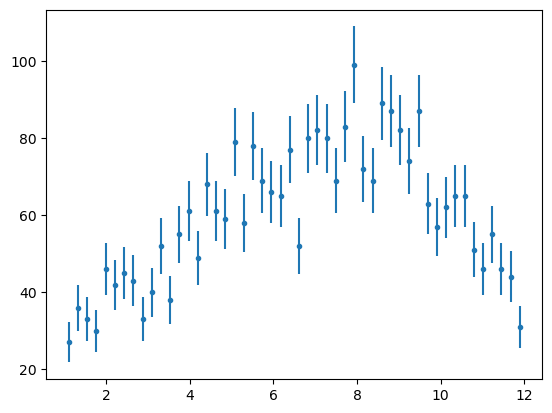

In [80]:
# Plot the histogram data with error bars
x,y,yerr = hist2np(hist)

plt.errorbar(x, y, yerr=yerr, fmt='.')

In [ ]:
# your work here